## 1. Imports


In [1]:
import sys
import gc
import random

import torch
from torch.utils.data import Subset
import torchvision.datasets as datasets
import numpy as np
from diffusers import DDIMScheduler
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

sys.path.append("..")
from utils import (
    set_random_seed,
    get_ddim_path,
    get_flow_path,
    get_all_pivotal,
    cod_prob_bound,
)

%matplotlib inline 

## 2. Config


In [2]:
SEED = 0x4090
set_random_seed(SEED)

# dataset choosing
DATASET, DATASET_PATH = "fmnist2mnist", "./data/"

IMG_SIZE = 28

# the step number adding noise in diffusion process
DIFFUSION_STEPS = 100
SCHEDULER = DDIMScheduler(num_train_timesteps=DIFFUSION_STEPS)
# All hyperparameters below is set to the values used for the experiments, which discribed in the article
EPSILON = 0.25
# R = 1000
N = 2
P = 1


# data sample settings
SUBSET_CLASS = 3

# plot settings
GRAY_PLOTS = True

## 3. Initialize samplers


In [3]:
source_transform = Compose(
    [
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize((0.5), (0.5)),
    ]
)
target_transform = source_transform

if DATASET == "fmnist2mnist":
    source = datasets.FashionMNIST
    target = datasets.MNIST
else:
    raise "Invalid dataset"

In [4]:
source_dataset = source(
    root=DATASET_PATH, train=True, download=True, transform=source_transform
)
target_dataset = target(
    root=DATASET_PATH, train=True, download=True, transform=target_transform
)

source_indices = [
    i for i, label in enumerate(source_dataset.targets) if label == SUBSET_CLASS
]
target_indices = [
    i for i, label in enumerate(target_dataset.targets) if label == SUBSET_CLASS
]
source_indices = source_indices[: min(len(source_indices), len(target_indices))]
target_indices = target_indices[: min(len(source_indices), len(target_indices))]


source_dataset = Subset(source_dataset, source_indices)
target_dataset = Subset(target_dataset, target_indices)

len(source_dataset), len(target_dataset)

(6000, 6000)

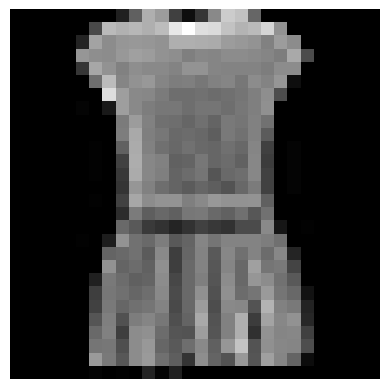

In [5]:
def plot_data_point(x):
    plt.imshow(x.squeeze().numpy(), cmap="gray")
    plt.axis("off")  # 不显示坐标轴
    plt.show()


plot_data_point(source_dataset[0][0])


In [6]:
from typing import Union


def plot_path(
    path: Union[list, torch.Tensor],
    gray: bool = False,
):
    if isinstance(path, list):
        path = torch.stack(path)

    imgs: np.ndarray = (
        path.to("cpu").permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1)
    )
    nrows, ncols = 1, len(path)
    fig = plt.figure(figsize=(1.5 * ncols, 1.5 * nrows), dpi=150)
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        if gray:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"$X_{{{i}}}$", fontsize=24)
        if i == imgs.shape[0] - 1:
            ax.set_title("Y", fontsize=24)

    torch.cuda.empty_cache()
    gc.collect()


## 4. Concentration of Distance Probability


### DDIM


#### MNIST: generate asymptotic distribution


In [7]:
y_path_list = []
for y, _ in tqdm(target_dataset, total=len(target_dataset)):
    path = get_ddim_path(y, SCHEDULER)
    path = torch.stack(path)
    y_path_list.append(path)

y_path_list = torch.stack(y_path_list)
asymptotic_dataset = y_path_list.transpose(0, 1)


  0%|          | 0/6000 [00:00<?, ?it/s]

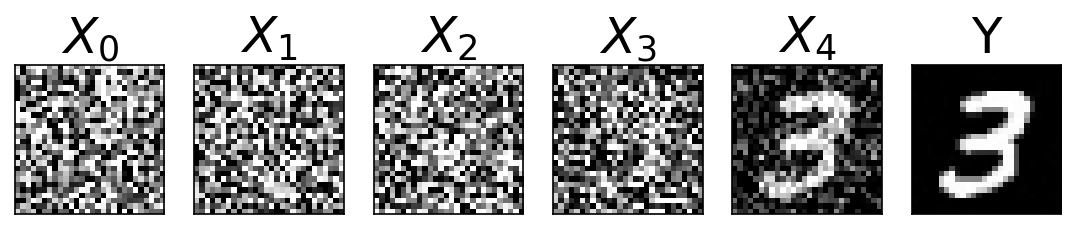

In [8]:
plot_path(
    y_path_list[0][[0, 19, 39, 59, 79, 99]],
    gray=GRAY_PLOTS,
)


#### MNIST: caculate CoD Prob Bound


In [9]:
Q_point_indices = np.random.choice(y_path_list.shape[0], 100, replace=False)
Q_point_dataset = asymptotic_dataset[0][Q_point_indices]
T_point_dataset = asymptotic_dataset[-1]

prob_bound_list = []
for Q_point in Q_point_dataset:
    prob_bound = cod_prob_bound(
        T_point_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
g2y_prob_bound = prob_bound_list.mean()

print(
    f"t={0} -> t={asymptotic_dataset.shape[0]-1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={g2y_prob_bound:.4%}"
)


t=0 -> t=100: P{DMAX(2)<=(1+0.25)DMIN(2)}>=98.5085%


In [10]:
g2y_ddim_prob_bound_list = []
for t in range(asymptotic_dataset.shape[0] - 1):
    Q_point_dataset = asymptotic_dataset[t][Q_point_indices]
    T_point_dataset = asymptotic_dataset[t + 1]

    # plot_data_point(Q_point)
    prob_bound_list = []
    for Q_point in Q_point_dataset:
        prob_bound = cod_prob_bound(
            T_point_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
        prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"t={t} -> t={t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

    g2y_ddim_prob_bound_list.append(prob_bound)


t=0 -> t=1: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0557%
t=1 -> t=2: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.1239%
t=2 -> t=3: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0920%
t=3 -> t=4: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.1214%
t=4 -> t=5: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9523%
t=5 -> t=6: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.1124%
t=6 -> t=7: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9191%
t=7 -> t=8: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8614%
t=8 -> t=9: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9644%
t=9 -> t=10: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9167%
t=10 -> t=11: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9538%
t=11 -> t=12: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8999%
t=12 -> t=13: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8903%
t=13 -> t=14: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8928%
t=14 -> t=15: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9242%
t=15 -> t=16: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8593%
t=16 -> t=17: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9366%
t=17 -> t=18: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9409%
t=18 -> t=19: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.7510%
t=19 -> t=20: P{DMAX(2)<=(1+0.2

#### FMNIST: generate asymptotic distribution


In [11]:
x_path_list = []
for x, _ in tqdm(source_dataset, total=len(source_dataset)):
    path = get_ddim_path(x, SCHEDULER, reverse=False)
    path = torch.stack(path)
    x_path_list.append(path)

x_path_list = torch.stack(x_path_list)
x_asymptotic_dataset = x_path_list.transpose(0, 1)


  0%|          | 0/6000 [00:00<?, ?it/s]

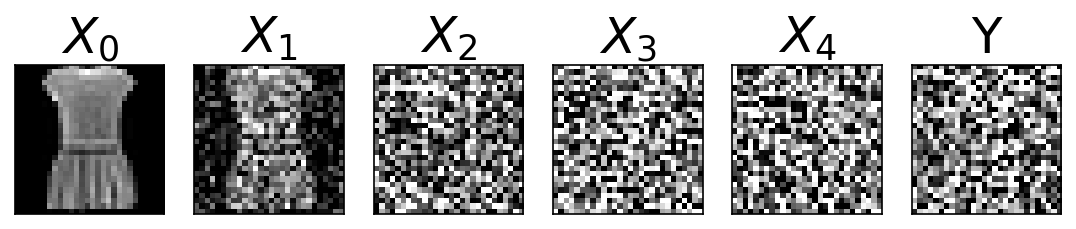

In [12]:
plot_path(
    x_path_list[0][[0, 19, 39, 59, 79, 99]],
    gray=GRAY_PLOTS,
)


#### FMNIST: caculate CoD Prob Bound


In [13]:
Q_point_indices = np.random.choice(x_path_list.shape[0], 100, replace=False)
Q_point_dataset = asymptotic_dataset[0][Q_point_indices]
T_point_dataset = asymptotic_dataset[-1]

prob_bound_list = []
for Q_point in Q_point_dataset:
    prob_bound = cod_prob_bound(
        T_point_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2g_prob_bound = prob_bound_list.mean()

print(
    f"t={0} -> t={asymptotic_dataset.shape[0]-1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2g_prob_bound:.4%}"
)


t=0 -> t=100: P{DMAX(2)<=(1+0.25)DMIN(2)}>=98.4918%


In [14]:
x2g_ddim_prob_bound_list = []
for t in range(asymptotic_dataset.shape[0] - 1):
    Q_point_dataset = asymptotic_dataset[t][Q_point_indices]
    T_point_dataset = asymptotic_dataset[t + 1]

    # plot_data_point(Q_point)
    prob_bound_list = []
    for Q_point in Q_point_dataset:
        prob_bound = cod_prob_bound(
            T_point_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
        prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"t={t} -> t={t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

    x2g_ddim_prob_bound_list.append(prob_bound)


t=0 -> t=1: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0669%
t=1 -> t=2: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0863%
t=2 -> t=3: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0759%
t=3 -> t=4: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.0805%
t=4 -> t=5: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9357%
t=5 -> t=6: P{DMAX(2)<=(1+0.25)DMIN(2)}>=92.1281%
t=6 -> t=7: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9378%
t=7 -> t=8: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8894%
t=8 -> t=9: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9324%
t=9 -> t=10: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9015%
t=10 -> t=11: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9228%
t=11 -> t=12: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8883%
t=12 -> t=13: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9108%
t=13 -> t=14: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9140%
t=14 -> t=15: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9514%
t=15 -> t=16: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8558%
t=16 -> t=17: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.8975%
t=17 -> t=18: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.9025%
t=18 -> t=19: P{DMAX(2)<=(1+0.25)DMIN(2)}>=91.7593%
t=19 -> t=20: P{DMAX(2)<=(1+0.2

## Flow


### generate asymptotic distribution


In [15]:
flow_path_list = []
for (x, _), (y, _) in tqdm(
    zip(source_dataset, target_dataset), total=len(source_dataset)
):
    path = get_flow_path(x, y, 100)
    path = torch.stack(path)
    flow_path_list.append(path)

flow_path_list = torch.stack(flow_path_list)
flow_asymptotic_dataset = flow_path_list.transpose(0, 1)


  0%|          | 0/6000 [00:00<?, ?it/s]

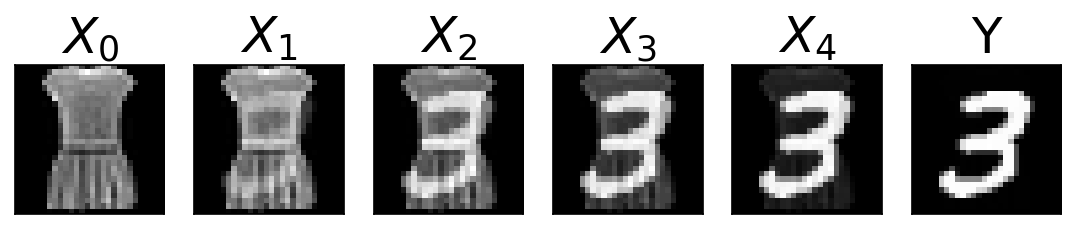

In [16]:
plot_path(
    flow_path_list[0][[0, 19, 39, 59, 79, 99]],
    gray=GRAY_PLOTS,
)


### caculate CoD Prob Bound


In [17]:
Q_point_indices = np.random.choice(flow_path_list.shape[0], 100, replace=False)

In [18]:
Q_point_dataset = flow_asymptotic_dataset[0][Q_point_indices]
T_point_dataset = flow_asymptotic_dataset[-1]

prob_bound_list = []
for Q_point in Q_point_dataset:
    prob_bound = cod_prob_bound(
        T_point_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2y_prob_bound = prob_bound_list.mean()

print(
    f"t={0} -> t={flow_asymptotic_dataset.shape[0]-1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2y_prob_bound:.4%}"
)


t=0 -> t=99: P{DMAX(2)<=(1+0.25)DMIN(2)}>=44.4615%


In [19]:
x2y_flow_prob_bound_list = []
for t in range(flow_asymptotic_dataset.shape[0] - 1):
    Q_point_dataset = flow_asymptotic_dataset[t][Q_point_indices]
    T_point_dataset = flow_asymptotic_dataset[t + 1]

    # plot_data_point(Q_point)
    prob_bound_list = []
    for Q_point in Q_point_dataset:
        prob_bound = cod_prob_bound(
            T_point_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
        prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"t={t} -> t={t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

    x2y_flow_prob_bound_list.append(prob_bound)


t=0 -> t=1: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0155%
t=1 -> t=2: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0157%
t=2 -> t=3: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0158%
t=3 -> t=4: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0161%
t=4 -> t=5: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0165%
t=5 -> t=6: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0170%
t=6 -> t=7: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0176%
t=7 -> t=8: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0183%
t=8 -> t=9: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0192%
t=9 -> t=10: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0202%
t=10 -> t=11: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0213%
t=11 -> t=12: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0227%
t=12 -> t=13: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0242%
t=13 -> t=14: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0259%
t=14 -> t=15: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0279%
t=15 -> t=16: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0301%
t=16 -> t=17: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0325%
t=17 -> t=18: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0353%
t=18 -> t=19: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0383%
t=19 -> t=20: P{DMAX(2)<=(1+0.25)DMIN(2)}>=0.0417%

# TODO LIST

0. []画图
1. []数据集
   - [] FMNIST, MNIST
   - [] comic_faces_v1
2. []多种渐变方式
   - [√] 扩散(DDIM)：并无直接 X->Y 的分布转移渐变，只有 X->高斯->Y 分布。但高斯分布本身会造成严重距离聚集。
   - [√] Flow(插值)
   - [] 薛定谔桥：渐进轨迹是学习得到的
